In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from os.path import join as pjoin
from matplotlib import pyplot as plt
import random
import warnings
import keras
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D,AveragePooling1D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# first we can see what does the feature look like
def get_raw_feature():
    video_data_dir='C:\\videofeature\\'
    X=[]
    Y=[]
    for video in os.listdir(video_data_dir):
        each_video= pjoin(video_data_dir,video)
        l=each_video.split('t_')[1]
        l=l.split('.')[0]
        LABEL=int(l)
        X.append(np.load(each_video))
        Y.append(LABEL)
    Video_label=pd.read_csv('label.csv')
    Video_label=np.array(Video_label)[:,:-1]
    return X,Y


## 1 Read features from 19 npy files

In [3]:
X,Y=get_raw_feature()
Video_label=pd.read_csv('label.csv')
Video_label=np.array(Video_label)[:,:-1]
print('there are ',len(X),'videos')
print('feature of video [0]',X[0].shape)
print('video [0] is from video' ,Y[0])
print(Y)

there are  19 videos
feature of video [0] (739, 14)
video [0] is from video 1
[1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 3, 4, 5, 6, 7, 8, 9]


Video_label contains detail labels and we can use Y to index them later.

In [4]:
Video_label

array([[1.33, 1.67, 1.  , 1.67, 1.33, 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.67, 1.  , 1.  , 1.67, 1.33, 1.33],
       [4.33, 4.33, 4.33, 4.33, 5.  , 4.67],
       [2.33, 1.67, 2.  , 2.  , 3.  , 2.33],
       [3.33, 3.33, 2.67, 3.33, 4.  , 3.67],
       [4.67, 4.  , 4.  , 4.67, 5.  , 4.67],
       [2.  , 2.  , 1.33, 1.  , 1.33, 2.33],
       [1.33, 1.67, 1.33, 1.33, 1.  , 1.67],
       [2.67, 2.67, 2.67, 2.33, 3.33, 3.  ],
       [1.33, 1.67, 1.  , 1.33, 2.  , 1.33],
       [2.67, 2.67, 1.67, 2.67, 2.67, 2.33],
       [3.67, 3.33, 3.  , 3.  , 3.67, 3.33],
       [1.67, 2.  , 1.  , 1.67, 1.67, 2.  ],
       [5.  , 5.  , 5.  , 4.67, 5.  , 4.67],
       [1.33, 1.  , 1.33, 1.  , 1.  , 1.67],
       [1.67, 1.67, 1.  , 2.  , 2.33, 1.67],
       [4.33, 4.33, 4.  , 4.  , 4.33, 4.33],
       [4.  , 3.  , 3.  , 4.5 , 4.  , 4.  ],
       [4.  , 3.5 , 4.5 , 4.  , 4.5 , 4.5 ]])

Here we create two functions to sample video clips from each video and get their time differences.


In [5]:
def get_diff_and_hstack_to_orginal_data(X,time_lag=2,move_threshold=200):
    original=X[:-time_lag]
    modified=X[time_lag:]
    result=modified-original
    ## threshold
    # consider there was no top in the first image and it showed up in the next image
    # the difference would be huge, which was not ideal.
    # so we need to filter these extrem value 
    result[np.abs(result)>move_threshold]=0
    
    return np.hstack((X[time_lag:],result))

##from each video sample video clips with size=window_L. you can specify stride 
def make_video_clips(matrix,window_L,stride):
    alldata=[]

    total_frame=matrix.shape[0]
    index=[n for n in range(1,total_frame,stride)]
    for start_index in index:
        if start_index+window_L> total_frame:
            break
#         print(start_index)
        each_clip_data=matrix[start_index:start_index+window_L]
        each_clip_data=np.transpose(each_clip_data)
#         print(each_clip_data.shape)
        alldata.append(each_clip_data)
    return np.array(alldata)

## 2 pre-processing the feature
make new 28-d feature and  sample video clips and add the 256-d auto encoder feature at the same time 

In [6]:
####################################### set video clips parameters
############################################### make new 28-d + 256-d feature
video_clips_length=30
time_lag=3
move_threshold=250
stride=15

auto_data_dir='C:\\auto_feature\\'
auto_X=[]
for video in os.listdir(auto_data_dir):
    each_video= pjoin(auto_data_dir,video)
    auto_X.append(np.load(each_video))
    
# cut the first 'time_lag' frame for auto feature 
for i in range(len(auto_X)):
    auto_X[i]=auto_X[i][time_lag:,:]

In [7]:

####################################### set video clips parameters
############################################### make new 28-d feature
all_data=[]
for each_auto,each_video,label in zip(auto_X,X,Y):

    re=get_diff_and_hstack_to_orginal_data(each_video,time_lag,move_threshold)
    combined_feature=np.hstack((re,each_auto))
    
    video_clip=make_video_clips(combined_feature,video_clips_length,stride)
#     print(video_clip.shape)
    all_data.append((video_clip))


So there are 19 videos and you can see how many video clips they have.

And next we will use leave one method to train the model.

## 3 prepare leave one data and give every video clips their label

In [8]:
# this function is used to stack 18 videos into a big matrix
# the dimenstion will be 
# (n1+n2..+n18,258+28,30)
# and the label will be (n1+n2..+n18,6)

def stack_video_clips_get_label(data,label):
    final_data=data[0]
    final_label=[label[0] for _ in range(final_data.shape[0])]
    for i in range(1,len(data)):
        final_data=np.vstack((final_data,data[i]))
        for j in range(data[i].shape[0]):
            final_label.append(label[i])
    return final_data,final_label

########## leave one and stack all video clips
def hold_out(X,Y,hold_number):
        new_label=Y.copy()
        new_data=X.copy()
        # find video n 's index
        index=new_label.index(hold_number)
        # get the video n and it's label
        X_test=new_data[index]
        hold_number_label=np.array([hold_number for _ in range(X_test.shape[0])])
        y_test=Video_label[hold_number_label-1]
        # so we can del them 
        del new_label[index]
        del new_data[index]

        final_data_X,final_data_Y=stack_video_clips_get_label(new_data,new_label)
        
        final_data_Y=np.array(final_data_Y)
        # the label of video 1 is Video_label[0]. 
        final_data_Y=Video_label[final_data_Y-1]
        return final_data_X,X_test,final_data_Y,y_test


In [9]:
# customized data generator
def generator(data, label, batch_size=128):
    while 1:
        rows = np.random.randint(0, data.shape[0], size=batch_size)
        samples = data[rows]
        y=label[rows]
        yield samples,y


In [10]:
# for each col, calculate the weighted average
def get_weighted_average(df):
    length=len(df)
    top=int(1/6*length)
    bottom=length-top
    df=np.array(df)
    df=np.sort(df)
    weghted_sum=np.sum(df[:top]*(1/6))+np.sum(df[top+1:bottom]*(2/3))+np.sum(df[bottom+1:]*(1/6))
    weghted_sum=weghted_sum/length
    return weghted_sum

# make the data frame
# Plot_data is the pridect result, which will have 6 scores
def get_video_score(Plot_data,GT):
    weight_ave_re=[]
    mean_re=[]
    median_re=[]
    pooled_re=[]
    
    for i in Plot_data.columns:
        weight_ave=get_weighted_average(Plot_data[i])
        weight_ave_re.append(weight_ave)
        
        mean_value=np.mean(Plot_data[i])   
        mean_re.append(mean_value)
        
        median_value = np.median(Plot_data[i])
        median_re.append(median_value)
        
        # pooling is also a weighted average 
        pooling = (weight_ave*0.333 + mean_value*0.333 + median_value*0.333)
        
        pooled_re.append(pooling)
        
    video_result=pd.DataFrame([weight_ave_re,mean_re,median_re,pooled_re,GT])
    video_result.columns = ['DP','BD','E','FS','A','RC']
    video_result.index = ['Weighted_average', 'Mean', 'Median','Cool_pooling','Ground_truth']
    return video_result
    


## 3 perform leave one cross validation  


In [11]:
# the model we will use
def make_model_1d(l2_lambda,clip_lenth,dimension):

    model = Sequential()
    model.add(Conv1D(filters=64, 
                     kernel_size=10, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda)))
    
    model.add(Conv1D(filters=64, 
                     kernel_size=10, 
                     padding='same',
                     activation='relu',
                     kernel_regularizer=l2(l2_lambda)))
    
    model.add(MaxPooling1D(3,
                          padding='same'))
    
    model.add(Conv1D(filters=128, 
                     kernel_size=5, 
                     padding='same',
                     activation='relu',
                     kernel_regularizer=l2(l2_lambda)))
    model.add(Conv1D(filters=128, 
                     kernel_size=5, 
                     padding='same',
                     activation='relu',
                     kernel_regularizer=l2(l2_lambda)))
    
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))
    
    model.compile(loss='mean_squared_error', # 'categorical_crossentropy' 'mean_squared_error' 'mean_absolute_percentage_error'
              optimizer='adam', # 'adadelta' 'rmsprop'
              )
    # model.summary()
    return model


In [12]:
def test_hold_out(hold_out_number):
    # using leave one cv to get train/test data
    X_train, X_test, y_train, y_test=hold_out(all_data,Y,hold_out_number)
    
    # scale all the value to 0-1
    X_train=X_train/640
    X_test=X_test/640
    y_train=y_train/5
    y_test=y_test/5
    # print(X_train.shape,y_train.shape)
    # print(X_test.shape,y_test.shape)

    sample_of_trainningdata=X_train.shape[0]
    sample_of_testdata=X_test.shape[0]


    batch_size=128
    l2=0.004


    train_gen=generator(X_train, y_train, batch_size)
    val_gen=generator(X_test, y_test, batch_size)
    
    #prepare for inout shape
    clip_lenth=X_train.shape[1]
    dimension=X_train.shape[2]
    
    #make cnn 1d
    cnn1d=make_model_1d(l2,clip_lenth,dimension)
    cnn1d_h=cnn1d.fit_generator(train_gen,
                        steps_per_epoch=int(sample_of_trainningdata/batch_size),
                        epochs=35,
                        validation_data=val_gen,
                       validation_steps=1,
                        verbose=0 )

    ax=plt.figure(figsize=(10,6))
    ax = plt.subplot(221)
    ax.plot(cnn1d_h.history['loss'])
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')

    ax = plt.subplot(222)
    ax.plot(cnn1d_h.history['val_loss'])
    plt.ylabel('valadation Loss')
    plt.xlabel('epochs')

    print('loss',cnn1d_h.history['val_loss'][-1])

    GT=list(Video_label[hold_out_number-1])
    
    #get pridect result
    predict=cnn1d.predict(X_test)
    re=predict*5
    Plot_data=pd.DataFrame(re,columns=['DP','BD','E','FS','A','RC'])
    video_result=get_video_score(Plot_data,GT)
    print(video_result)

    y=[x for x in range(1,7)]
    ax = plt.subplot(223)
    gt=video_result.iloc[4]
    re=video_result.iloc[3]
    ax.plot(y, re, label='predict')
    ax.plot(y, gt, label='ground truth')
    plt.ylim(0,5.5)
    ax.legend()
    plt.show()

[1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 3, 4, 5, 6, 7, 8, 9]
you can try the video number above
loss 0.09982167929410934
                        DP        BD         E        FS         A        RC
Weighted_average  1.419071  1.344124  1.212127  1.345939  1.515219  1.474375
Mean              2.933085  2.777906  2.506605  2.782664  3.130732  3.046286
Median            2.943193  2.787966  2.513396  2.791153  3.143283  3.058566
Cool_pooling      2.429351  2.301029  2.075299  2.304279  2.593815  2.523882
Ground_truth      1.330000  1.670000  1.000000  1.670000  1.330000  1.000000


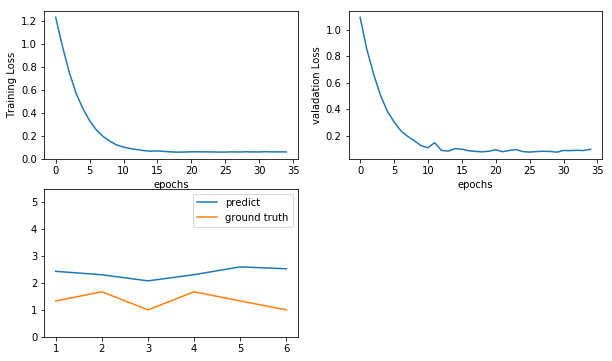

In [13]:
print(Y)
print("you can try the video number above")
test_hold_out(1)

video 1
loss 0.07940779626369476
                        DP        BD         E        FS         A        RC
Weighted_average  1.339304  1.258272  1.148079  1.269945  1.423200  1.385320
Mean              2.774963  2.607069  2.378754  2.631253  2.948791  2.870302
Median            2.774961  2.607068  2.378754  2.631252  2.948790  2.870302
Cool_pooling      2.294113  2.155312  1.966561  2.175306  2.437820  2.372933
Ground_truth      1.330000  1.670000  1.000000  1.670000  1.330000  1.000000


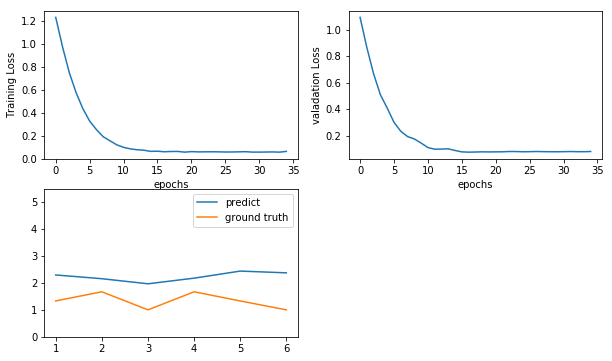

video 10
loss 0.0034483689814805984
                        DP        BD         E        FS         A        RC
Weighted_average  1.344394  1.277852  1.149382  1.296988  1.401875  1.368603
Mean              2.717545  2.583039  2.323349  2.621720  2.833739  2.766480
Median            2.717545  2.583039  2.323349  2.621720  2.833737  2.766480
Cool_pooling      2.257568  2.145828  1.930095  2.177963  2.354094  2.298220
Ground_truth      2.670000  2.670000  2.670000  2.330000  3.330000  3.000000


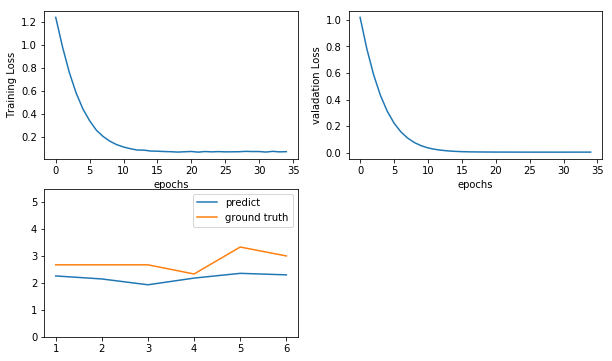

video 11
loss 0.06469331681728363
                        DP        BD         E        FS         A        RC
Weighted_average  1.337422  1.261879  1.148797  1.277873  1.398949  1.371427
Mean              2.771063  2.614541  2.380242  2.647681  2.898543  2.841516
Median            2.771062  2.614542  2.380242  2.647679  2.898541  2.841517
Cool_pooling      2.290889  2.161490  1.967790  2.188887  2.396279  2.349135
Ground_truth      1.330000  1.670000  1.000000  1.330000  2.000000  1.330000


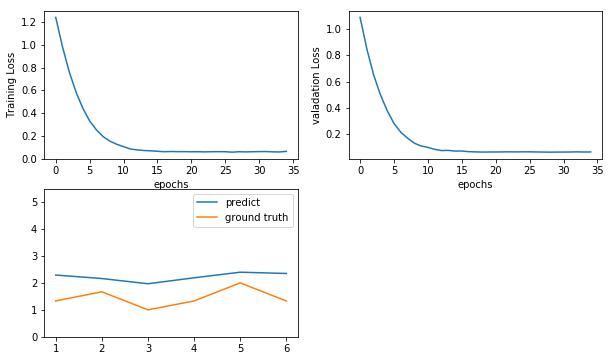

video 12
loss 0.005062159616500139
                        DP        BD         E        FS         A        RC
Weighted_average  1.343329  1.274819  1.183274  1.285924  1.428077  1.394657
Mean              2.686659  2.549637  2.366547  2.571846  2.856155  2.789314
Median            2.686657  2.549637  2.366549  2.571848  2.856154  2.789314
Cool_pooling      2.236643  2.122573  1.970151  2.141063  2.377749  2.322104
Ground_truth      2.670000  2.670000  1.670000  2.670000  2.670000  2.330000


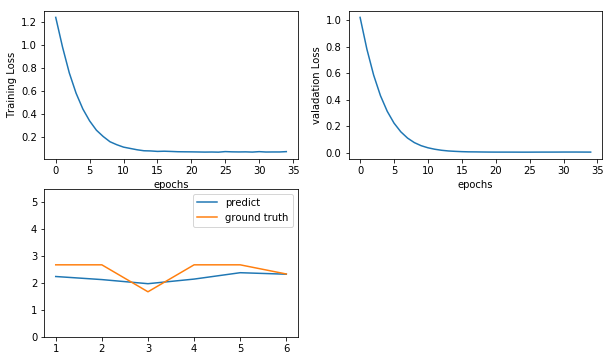

video 13
loss 0.021765656769275665
                        DP        BD         E        FS         A        RC
Weighted_average  1.335208  1.278956  1.151166  1.293743  1.420412  1.380256
Mean              2.670416  2.557913  2.302332  2.587486  2.840822  2.760513
Median            2.670416  2.557912  2.302332  2.587485  2.840823  2.760511
Cool_pooling      2.223121  2.129462  1.916692  2.154082  2.364985  2.298126
Ground_truth      3.670000  3.330000  3.000000  3.000000  3.670000  3.330000


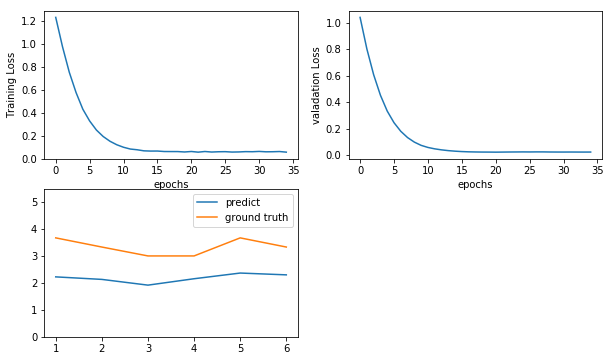

video 14
loss 0.04712953418493271
                        DP        BD         E        FS         A        RC
Weighted_average  1.395738  1.316959  1.209193  1.340762  1.479324  1.421696
Mean              2.791474  2.633919  2.418387  2.681526  2.958648  2.843392
Median            2.791475  2.633918  2.418386  2.681524  2.958648  2.843392
Cool_pooling      2.323903  2.192737  2.013306  2.232369  2.463075  2.367124
Ground_truth      1.670000  2.000000  1.000000  1.670000  1.670000  2.000000


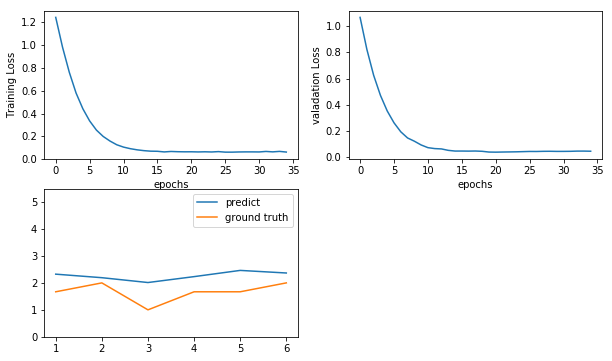

video 15
loss 0.21373800933361053
                        DP        BD         E        FS         A        RC
Weighted_average  1.274748  1.198868  1.081651  1.221522  1.355724  1.314284
Mean              2.664080  2.505501  2.260529  2.552842  2.833311  2.746706
Median            2.664080  2.505500  2.260529  2.552843  2.833310  2.746706
Cool_pooling      2.198768  2.067886  1.865702  2.106960  2.338441  2.266963
Ground_truth      5.000000  5.000000  5.000000  4.670000  5.000000  4.670000


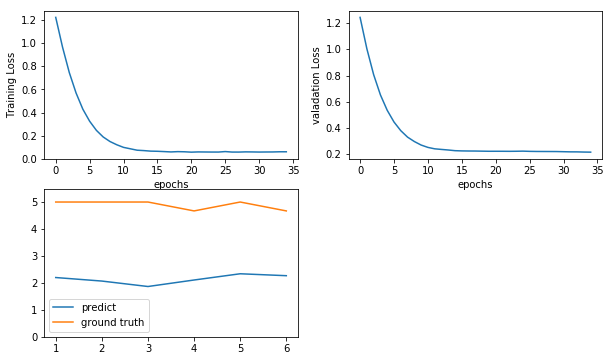

video 16
loss 0.09766343981027603
                        DP        BD         E        FS         A        RC
Weighted_average  1.406661  1.343452  1.200261  1.356888  1.508621  1.437044
Mean              2.813323  2.686904  2.400522  2.713776  3.017242  2.874086
Median            2.813322  2.686903  2.400522  2.713776  3.017242  2.874087
Cool_pooling      2.342091  2.236847  1.998435  2.259219  2.511854  2.392677
Ground_truth      1.330000  1.000000  1.330000  1.000000  1.000000  1.670000


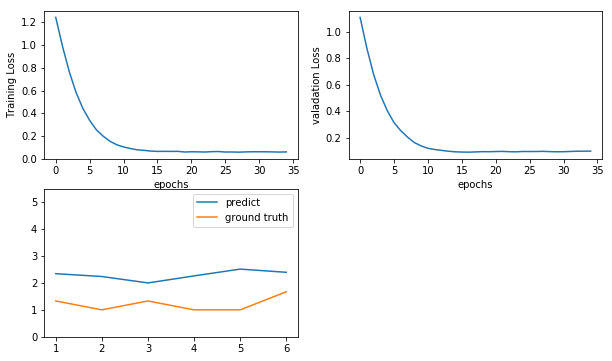

video 17
loss 0.04274425655603409
                        DP        BD         E        FS         A        RC
Weighted_average  1.397398  1.321796  1.206922  1.326324  1.462636  1.430357
Mean              2.794794  2.643592  2.413843  2.652648  2.925272  2.860716
Median            2.794796  2.643591  2.413845  2.652648  2.925272  2.860714
Cool_pooling      2.326667  2.200790  2.009525  2.208330  2.435289  2.381545
Ground_truth      1.670000  1.670000  1.000000  2.000000  2.330000  1.670000


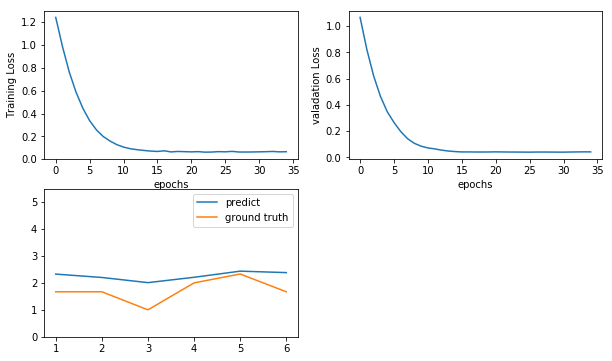

video 18
loss 0.10776206105947495
                        DP        BD         E        FS         A        RC
Weighted_average  1.323982  1.253331  1.132613  1.274326  1.409262  1.357423
Mean              2.647965  2.506662  2.265228  2.548652  2.818526  2.714845
Median            2.647965  2.506663  2.265227  2.548652  2.818524  2.714846
Cool_pooling      2.204431  2.086796  1.885801  2.121753  2.346422  2.260109
Ground_truth      4.330000  4.330000  4.000000  4.000000  4.330000  4.330000


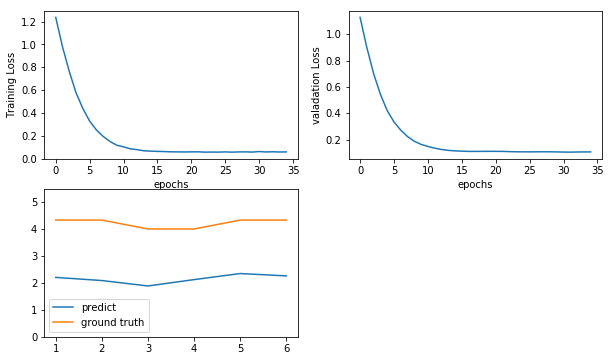

video 19
loss 0.06297721713781357
                        DP        BD         E        FS         A        RC
Weighted_average  1.283886  1.244737  1.110459  1.221750  1.369942  1.316112
Mean              2.649941  2.569138  2.291987  2.521692  2.827561  2.716454
Median            2.649941  2.569138  2.291987  2.521693  2.827561  2.716455
Cool_pooling      2.192395  2.125543  1.896246  2.086290  2.339346  2.247424
Ground_truth      4.000000  3.000000  3.000000  4.500000  4.000000  4.000000


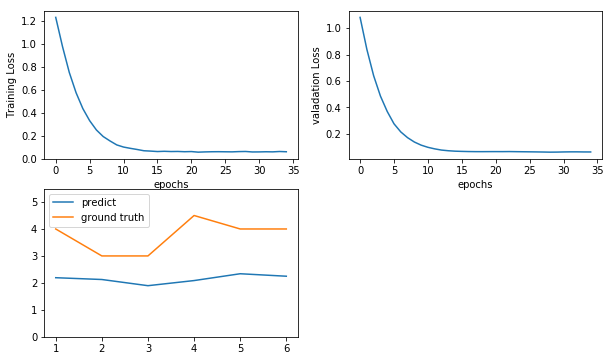

video 20
loss 0.10646261274814606
                        DP        BD         E        FS         A        RC
Weighted_average  1.309147  1.256121  1.098528  1.248059  1.383367  1.333729
Mean              2.663831  2.555932  2.235265  2.539528  2.814850  2.713850
Median            2.663831  2.555933  2.235265  2.539528  2.814851  2.713849
Cool_pooling      2.210058  2.120539  1.854496  2.106929  2.335352  2.251555
Ground_truth      4.000000  3.500000  4.500000  4.000000  4.500000  4.500000


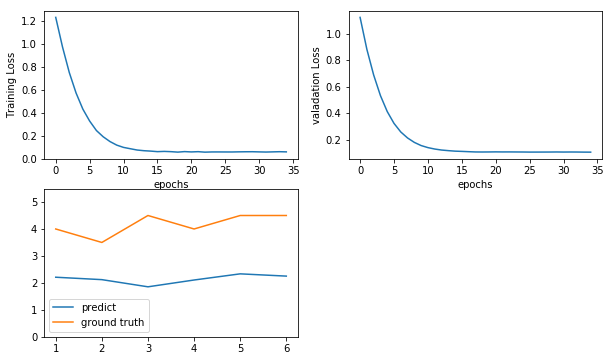

video 3
loss 0.08121056854724884
                        DP        BD         E        FS         A        RC
Weighted_average  1.384369  1.330842  1.198495  1.322436  1.481498  1.431350
Mean              2.786601  2.678855  2.412454  2.661935  2.982112  2.881170
Median            2.786601  2.678856  2.412455  2.661935  2.982111  2.881170
Cool_pooling      2.316871  2.227288  2.005794  2.213220  2.479425  2.395499
Ground_truth      1.670000  1.000000  1.000000  1.670000  1.330000  1.330000


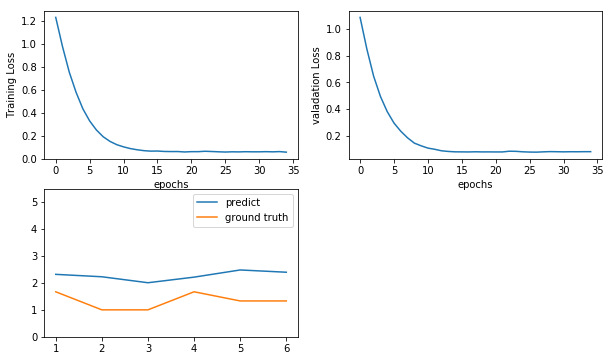

video 4
loss 0.156526118516922
                        DP        BD         E        FS         A        RC
Weighted_average  1.260105  1.185814  1.064131  1.204710  1.324955  1.282490
Mean              2.610863  2.456938  2.204819  2.496092  2.745231  2.657244
Median            2.610864  2.456937  2.204819  2.496090  2.745231  2.657245
Cool_pooling      2.158450  2.031196  1.822765  2.063565  2.269534  2.196794
Ground_truth      4.330000  4.330000  4.330000  4.330000  5.000000  4.670000


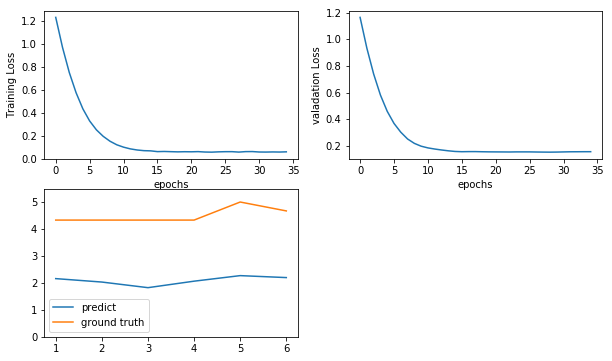

video 5
loss 0.012694140896201134
                        DP        BD         E        FS         A        RC
Weighted_average  1.320300  1.277632  1.135651  1.272046  1.390112  1.360995
Mean              2.735586  2.647180  2.353004  2.635605  2.880233  2.819902
Median            2.735585  2.647182  2.353003  2.635606  2.880233  2.819904
Cool_pooling      2.261560  2.188474  1.945272  2.178905  2.381142  2.331267
Ground_truth      2.330000  1.670000  2.000000  2.000000  3.000000  2.330000


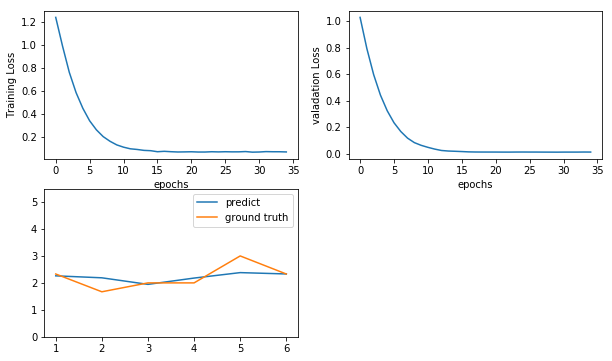

video 6
loss 0.026621391996741295
                        DP        BD         E        FS         A        RC
Weighted_average  1.343968  1.264463  1.155440  1.286000  1.413614  1.371537
Mean              2.687935  2.528928  2.310880  2.571999  2.827226  2.743073
Median            2.687936  2.528927  2.310880  2.571999  2.827227  2.743074
Cool_pooling      2.237706  2.105332  1.923808  2.141189  2.353666  2.283609
Ground_truth      3.330000  3.330000  2.670000  3.330000  4.000000  3.670000


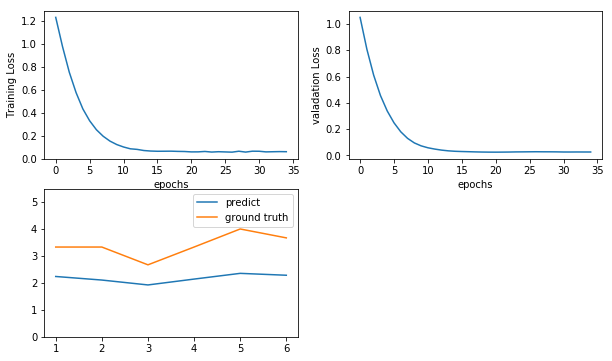

video 7
loss 0.15469762682914734
                        DP        BD         E        FS         A        RC
Weighted_average  1.266885  1.217046  1.081349  1.207108  1.342951  1.302191
Mean              2.614852  2.511984  2.231903  2.491471  2.771850  2.687721
Median            2.614851  2.511983  2.231904  2.491472  2.771849  2.687722
Cool_pooling      2.163364  2.078258  1.846537  2.061287  2.293254  2.223652
Ground_truth      4.670000  4.000000  4.000000  4.670000  5.000000  4.670000


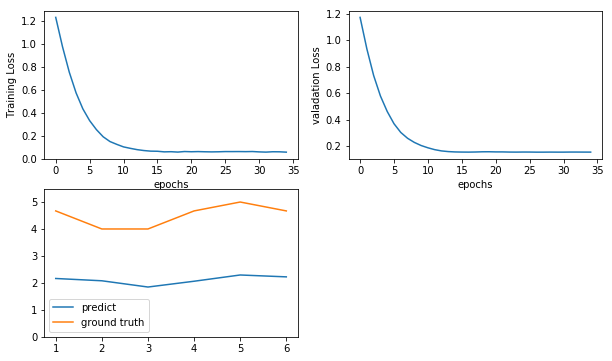

video 8
loss 0.05146036297082901
                        DP        BD         E        FS         A        RC
Weighted_average  1.323425  1.252222  1.150645  1.297837  1.425017  1.349031
Mean              2.742060  2.594530  2.384071  2.689043  2.952552  2.795115
Median            2.742061  2.594532  2.384070  2.689044  2.952553  2.795115
Cool_pooling      2.266913  2.144947  1.970956  2.223083  2.440930  2.310774
Ground_truth      2.000000  2.000000  1.330000  1.000000  1.330000  2.330000


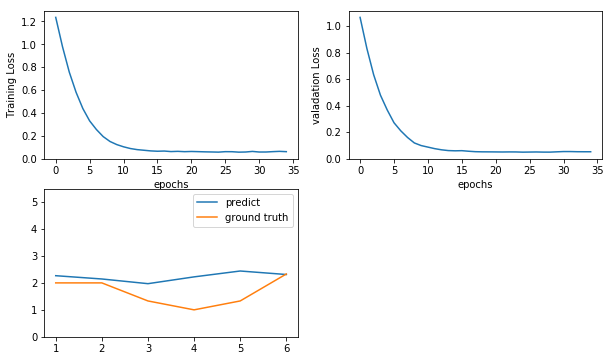

video 9
loss 0.07322681695222855
                        DP        BD         E        FS         A        RC
Weighted_average  1.344392  1.270604  1.152383  1.295829  1.442466  1.369601
Mean              2.763993  2.612290  2.369234  2.664152  2.965631  2.815825
Median            2.763994  2.612290  2.369234  2.664151  2.965630  2.815823
Cool_pooling      2.288502  2.162896  1.961653  2.205836  2.455451  2.331416
Ground_truth      1.330000  1.670000  1.330000  1.330000  1.000000  1.670000


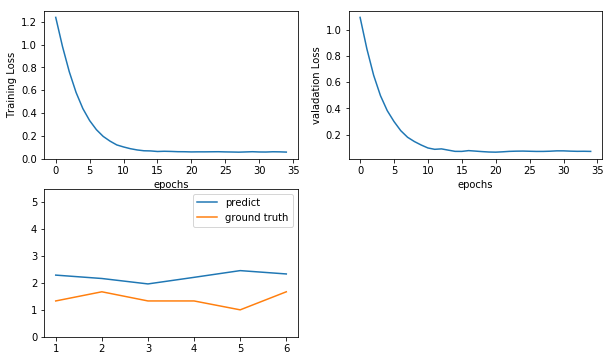

In [14]:
# un-comment the code blow to test all the video

for i in Y:
    print('video',i)
    test_hold_out(i)
